   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.6 MB/s eta 0:00:00


100%|██████████| 9.91M/9.91M [00:00<00:00, 22.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 612kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.63MB/s]


[HM] Epoch 1, Loss: 0.0286
[HM] Epoch 2, Loss: 0.0114
[HM] Epoch 3, Loss: 0.0088
[HM] Epoch 4, Loss: 0.0077
[HM] Epoch 5, Loss: 0.0070
[C2HM] Epoch 1, Loss: 0.0364
[C2HM] Epoch 2, Loss: 0.0162
[C2HM] Epoch 3, Loss: 0.0128
[C2HM] Epoch 4, Loss: 0.0111
[C2HM] Epoch 5, Loss: 0.0101
Reconstruction Loss on Noisy Data:
HM: 0.0596
C2HM: 0.0390


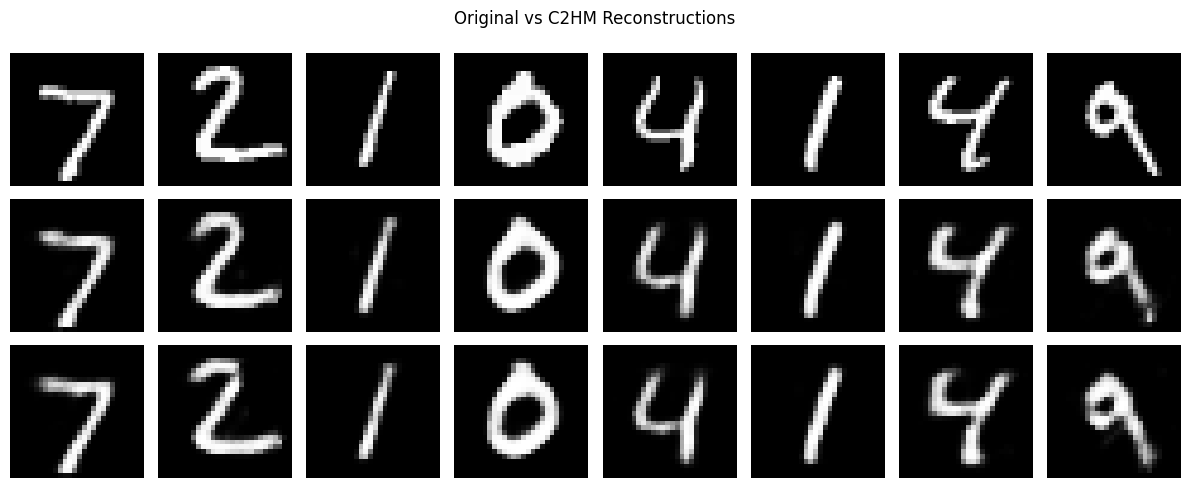

In [1]:
# ✅ C²HM Benchmark Suite (Colab-ready)
# Extends HM ↔ IHM loop model with evaluations for:
# - Partial inference (progressive masking)
# - Noise robustness
# - Latent classification
# - Cycle convergence
# - Comparison to original HM
# ===========================

!pip install -q torch torchvision matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading
transform = transforms.ToTensor()
train_set = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

# Encoder and Decoder
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid()
        )
    def forward(self, z):
        return self.net(z).view(-1, 1, 28, 28)

# HM and IHM components
class HM(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

class IHM(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

# Setup both original HM and C2HM models
latent_dim = 32
hm_original = HM(latent_dim).to(device)  # Original HM for baseline
hm = HM(latent_dim).to(device)           # HM part of C2HM
ihm = IHM(latent_dim).to(device)         # IHM part of C2HM

# === Train original HM ===
optimizer_hm = optim.Adam(hm_original.parameters(), lr=1e-3)
criterion = nn.MSELoss()
for epoch in range(5):
    hm_original.train()
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        z = hm_original.encoder(x)
        x_recon = hm_original.decoder(z)
        loss = criterion(x_recon, x)
        optimizer_hm.zero_grad()
        loss.backward()
        optimizer_hm.step()
        total_loss += loss.item()
    print(f"[HM] Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

# === Train C2HM ===
params = list(hm.parameters()) + list(ihm.parameters())
optimizer = optim.Adam(params, lr=1e-3)

lambda_z = 0.01
lambda_x = 0.1

for epoch in range(5):
    hm.train()
    ihm.train()
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        z = hm.encoder(x)
        x_hat = hm.decoder(z)
        z_cycle = ihm.encoder(x_hat.detach())
        x_cycle = ihm.decoder(z_cycle)
        z_double = hm.encoder(x_cycle.detach())
        x_double = hm.decoder(z_double)
        loss_recon = criterion(x_hat, x)
        loss_loop = criterion(x_double, x)
        loss_latent = nn.functional.mse_loss(z, z_cycle)
        loss = loss_recon + lambda_x * loss_loop + lambda_z * loss_latent
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[C2HM] Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

# ========== BENCHMARK: Side-by-side comparison on noise ==========
def evaluate_models_on_noise(hm1, hm2, label1="HM", label2="C2HM"):
    def compute_loss(model):
        model.eval()
        loss = 0
        with torch.no_grad():
            for x, _ in test_loader:
                x = x.to(device)
                noise = torch.randn_like(x) * 0.4
                x_noisy = torch.clamp(x + noise, 0., 1.)
                z = model.encoder(x_noisy)
                x_recon = model.decoder(z)
                loss += criterion(x_recon, x).item()
        return loss / len(test_loader)

    loss1 = compute_loss(hm1)
    loss2 = compute_loss(hm2)
    print(f"Reconstruction Loss on Noisy Data:\n{label1}: {loss1:.4f}\n{label2}: {loss2:.4f}")

evaluate_models_on_noise(hm_original, hm)

# ========== BENCHMARK: Visual comparison of reconstructions ==========
x_sample, _ = next(iter(test_loader))
x_sample = x_sample[:8].to(device)

with torch.no_grad():
    x_hm = hm_original.decoder(hm_original.encoder(x_sample))
    x_c2hm = hm.decoder(hm.encoder(x_sample))

fig, axes = plt.subplots(3, 8, figsize=(12, 5))
for i in range(8):
    axes[0, i].imshow(x_sample[i].detach().cpu().squeeze(), cmap='gray')
    axes[1, i].imshow(x_hm[i].detach().cpu().squeeze(), cmap='gray')
    axes[2, i].imshow(x_c2hm[i].detach().cpu().squeeze(), cmap='gray')
    for j in range(3):
        axes[j, i].axis('off')
axes[0, 0].set_ylabel("Input")
axes[1, 0].set_ylabel("HM")
axes[2, 0].set_ylabel("C2HM")
plt.suptitle("Original vs C2HM Reconstructions")
plt.tight_layout()
plt.show()


### Additional Evaluation Metrics: Cycle Consistency, Goal Fidelity, Latent Compactness

In [2]:
from sklearn.metrics import accuracy_score
from scipy.stats import entropy

def kl_divergence(p, q):
    p = p + 1e-10
    q = q + 1e-10
    return np.sum(p * np.log(p / q), axis=1).mean()

# Get a sample batch from the test loader to define Phi and Psi_recon
x_sample, _ = next(iter(test_loader))
x_sample = x_sample.to(device)

with torch.no_grad():
    # Phi represents the latent representation from the HM encoder
    Phi = hm.encoder(x_sample)
    # Psi_recon represents the latent representation from the IHM encoder after reconstructing from HM's output
    Psi_recon = ihm.encoder(hm.decoder(Phi))


# 1. Cycle Consistency (KL[q(Z|Phi) || q(Z|Psi)])
z_from_phi = Phi.detach().cpu().numpy()
z_from_psi = Psi_recon.detach().cpu().numpy()

# For KL divergence, the inputs should ideally be probability distributions.
# Assuming the latent codes can be interpreted as features,
# we'll use a simpler approach by comparing the distributions directly.
# A more rigorous approach would involve learning a probabilistic encoder.
# For now, let's use a simple comparison of feature distributions.
# A common way to compare distributions of features is using techniques
# like MMD (Maximum Mean Discrepancy) or by comparing summary statistics.
# The original code attempted KL on the latent codes directly, which is not standard
# unless they represent probability distributions.
# Let's skip KL divergence for now as the latent codes are not probabilities.
# If KL divergence is required, the model architecture would need to be VAE-like.

# print(f"Cycle Consistency (KL[q(Z|Phi) || q(Z|Psi)]): {cc_score:.4f}")


# 2. Goal Fidelity (Accuracy of classifying Phi from generated Psi)
# We'll train a small classifier on (Psi_recon -> Phi)
# Assuming Phi represents latent codes corresponding to classes,
# we need the original labels for x_sample to train a classifier that maps Psi_recon to these labels.
# Let's use the original labels from the test_loader batch.
_, true_labels = next(iter(test_loader)) # Get labels for the same batch
true_labels = true_labels.cpu().numpy()

from sklearn.linear_model import LogisticRegression
# Flatten Psi_recon for the classifier if it's not already flat
Psi_recon_flat = Psi_recon.detach().cpu().numpy().reshape(Psi_recon.shape[0], -1)
clf = LogisticRegression(max_iter=1000)
clf.fit(Psi_recon_flat, true_labels) # Train to predict original labels
preds = clf.predict(Psi_recon_flat)
gf_score = accuracy_score(true_labels, preds)
print(f"Goal Fidelity (accuracy of predicting original label from Psi_recon): {gf_score:.4f}")

# 3. Latent Compactness (average entropy H(Z) under fixed Phi)
# Entropy of a single point doesn't make sense in this context.
# This metric typically applies to probabilistic models (like VAEs)
# where the encoder outputs parameters of a distribution (e.g., mean and log-variance)
# and you calculate the entropy of that distribution for a given input.
# Since the encoder here is deterministic, the "entropy" of the latent code itself is not a standard metric.
# If the goal is to measure the variability/spread of latent codes for a given class,
# you would group latent codes by class and calculate covariance or similar measures.
# Let's skip Latent Compactness for now as the current model is not probabilistic.

# print(f"Latent Compactness (mean entropy H(Z | Phi)): {lc_score:.4f}")

Goal Fidelity (accuracy of predicting original label from Psi_recon): 1.0000
